### Rishu Raj Singh (2023AIB2080)

## Configuration 4

In [1]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 844.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.6 MB/s eta 0:00:00


In [2]:
import math
from dataclasses import dataclass
import os
import numpy as np
import sacrebleu
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from tqdm import tqdm
import pandas
torch.manual_seed(0)
import random
random.seed(0)
import  pathlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchinfo import summary

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [3]:
SRC = "en"
TRG = "fr"
en_vocab_size = 5000
fr_vocab_size = 5000
vocab_sizes = {"en": en_vocab_size, "fr": fr_vocab_size}
max_seq_len = 72

In [4]:
full_set = pandas.read_csv("/kaggle/input/dataset-1/eng_-french.csv")

temp_train_set, test_set = train_test_split(full_set, test_size=0.3, random_state=42)
full_train_set, valid_set = train_test_split(temp_train_set, test_size=0.1, random_state=42)

print(len(full_train_set), len(valid_set), len(test_set))

110640 12294 52687


In [5]:
full_train_set.head(3)

,English words/sentences,French words/sentences
1660,That hurts.,Ça fait mal.
89279,I can't function without you.,Je n'arrive pas à fonctionner sans toi.
144858,Let's talk about what you did in Boston.,Parlons de ce que tu as fait à Boston.


In [6]:
from tokenizers import Tokenizer, models, pre_tokenizers, trainers, decoders

# This library has been used only for tokenization purpose because French sentences contains 
# distinct type of character which is diificult to capture normally.

def get_tokenizers(dataset, train_set_size):
    en_sentences = dataset['English words/sentences'].iloc[:train_set_size].tolist()
    fr_sentences = dataset['French words/sentences'].iloc[:train_set_size].tolist()

    # Write English and French sentences to temporary files
    en_file = 'temp_en_sentences.txt'
    fr_file = 'temp_fr_sentences.txt'
    with open(en_file, 'w', encoding='utf-8') as f_en, open(fr_file, 'w', encoding='utf-8') as f_fr:
        for en_sent, fr_sent in zip(en_sentences, fr_sentences):
            f_en.write(en_sent + '\n')
            f_fr.write(fr_sent + '\n')

    # Initialize a tokenizer
    en_tokenizer = Tokenizer(models.BPE())
    fr_tokenizer = Tokenizer(models.BPE())

    # Customize pre-tokenization and decoding
    en_tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    fr_tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    en_tokenizer.decoder = decoders.BPEDecoder()
    fr_tokenizer.decoder = decoders.BPEDecoder()

    en_tokenizer.train([en_file], trainer=trainers.BpeTrainer(vocab_size=en_vocab_size, special_tokens=["<pad>"]))
    fr_tokenizer.train([fr_file], trainer=trainers.BpeTrainer(vocab_size=fr_vocab_size, special_tokens=["<pad>"]))

    # Define the tokenization and detokenization functions
    tokenizers = {"en": lambda sent: en_tokenizer.encode(sent).ids, "fr": lambda sent: fr_tokenizer.encode(sent).ids}
    detokenizers = {"en": lambda ids: ' '.join([en_tokenizer.id_to_token(id) for id in ids]), 
                    "fr": lambda ids: ' '.join([fr_tokenizer.id_to_token(id) for id in ids])}
    # Cleanup temporary files
    os.remove(en_file)
    os.remove(fr_file)

    return tokenizers, detokenizers


In [7]:
tokenizers, detokenizers = get_tokenizers(full_train_set, len(full_set))
print(tokenizers['fr']("De quoi ai-je l'air ?"))
print(tokenizers['en']('How do I look?'))

# indexes of special symbols
UNK, BOS, EOS, PAD = 0, 1, 2, 3







[645, 238, 106, 10, 167, 63, 6, 488, 25]
[238, 114, 32, 274, 23]


In [8]:
def tokenize_dataset(dataset):
    """
    Tokenize a dataset and add [BOS] and [EOS] to the beginning and end of the sentences.
    """
    if SRC == "en":
        return [(torch.tensor([BOS]+tokenizers[SRC](src_text)[0:max_seq_len-2]+[EOS]),
                 torch.tensor([BOS]+tokenizers[TRG](trg_text)[0:max_seq_len-2]+[EOS]))
                 for src_text, trg_text in dataset]
    else:
        return [(torch.tensor([BOS]+tokenizers[SRC](src_text)[0:max_seq_len-2]+[EOS]),
                 torch.tensor([BOS]+tokenizers[TRG](trg_text)[0:max_seq_len-2]+[EOS]))
                 for trg_text, src_text in dataset]
    

class TranslationDataset(Dataset):
    'create a dataset for torch.utils.data.DataLoader() '
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def pad_sequence(batch):
    'collate function for padding sentences such that all \
    the sentences in the batch have the same length'
    src_seqs  = [src for src, trg in batch]
    trg_seqs  = [trg for src, trg in batch]
    src_padded = torch.nn.utils.rnn.pad_sequence(src_seqs,
                                batch_first=True, padding_value = PAD)
    trg_padded = torch.nn.utils.rnn.pad_sequence(trg_seqs,
                                batch_first=True, padding_value = PAD)
    return src_padded, trg_padded

In [9]:
batch_size = 32

class Dataloaders:
    'Dataloaders contains train_loader, test_loader and valid_loader for training and evaluation '
    def __init__(self):
        # train_set = list(full_train_set)[0:train_set_size]
        train_set_1 = [(row['English words/sentences'], row['French words/sentences']) for index, row in full_train_set.iterrows()]
        valid_set_1 = [(row['English words/sentences'], row['French words/sentences']) for index, row in valid_set.iterrows()]
        test_set_1 = [(row['English words/sentences'], row['French words/sentences']) for index, row in test_set.iterrows()]
        # print(train_set)
        train_dataset = TranslationDataset(tokenize_dataset(train_set_1))
        valid_dataset = TranslationDataset(tokenize_dataset(valid_set_1))
        test_dataset  = TranslationDataset(tokenize_dataset(test_set_1))

        # each batch returned by dataloader will be padded such that all the texts in
        # that batch have the same length as the longest text in that batch
        self.train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                                shuffle=True, collate_fn = pad_sequence)

        self.test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                                shuffle=True, collate_fn=pad_sequence)

        self.valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                                shuffle=True, collate_fn=pad_sequence)

In [10]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_embed, dropout=0.0):
        super(MultiHeadedAttention, self).__init__()
        assert d_embed % h == 0 # check the h number
        self.d_k = d_embed//h
        self.d_embed = d_embed
        self.h = h
        self.WQ = nn.Linear(d_embed, d_embed)
        self.WK = nn.Linear(d_embed, d_embed)
        self.WV = nn.Linear(d_embed, d_embed)
        self.linear = nn.Linear(d_embed, d_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_query, x_key, x_value, mask=None):
        nbatch = x_query.size(0) # get batch size
        # 1) Linear projections to get the multi-head query, key and value tensors
        # x_query, x_key, x_value dimension: nbatch * seq_len * d_embed
        # LHS query, key, value dimensions: nbatch * h * seq_len * d_k
        query = self.WQ(x_query).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        key   = self.WK(x_key).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        value = self.WV(x_value).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        # 2) Attention
        # scores has dimensions: nbatch * h * seq_len * seq_len
        scores = torch.matmul(query, key.transpose(-2, -1))/math.sqrt(self.d_k)
        # 3) Mask out padding tokens and future tokens
        if mask is not None:
            scores = scores.masked_fill(mask, float('-inf'))
        # p_atten dimensions: nbatch * h * seq_len * seq_len
        p_atten = torch.nn.functional.softmax(scores, dim=-1)
        p_atten = self.dropout(p_atten)
        # x dimensions: nbatch * h * seq_len * d_k
        x = torch.matmul(p_atten, value)
        # x now has dimensions:nbtach * seq_len * d_embed
        x = x.transpose(1, 2).contiguous().view(nbatch, -1, self.d_embed)
        return self.linear(x) # final linear layer


class ResidualConnection(nn.Module):
    '''residual connection: x + dropout(sublayer(layernorm(x))) '''
    def __init__(self, dim, dropout):
        super().__init__()
        self.drop = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, sublayer):
        return x + self.drop(sublayer(self.norm(x)))


class PositionalEncoding(nn.Module):
    def __init__(self, d_embed, max_seq_len=5000):
        super(PositionalEncoding, self).__init__()
        self.d_embed = d_embed
        # Compute the positional encodings in log space
        pe = torch.zeros(max_seq_len, d_embed)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_embed, 2).float() * (-math.log(10000.0) / d_embed))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Add batch dimension
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add positional encodings to the input embeddings
        return x + self.pe[:, :x.size(1), :]


class Encoder(nn.Module):
    '''Encoder = token embedding + positional embedding -> a stack of N EncoderBlock -> layer norm'''
    def __init__(self, config):
        super().__init__()
        self.d_embed = config.d_embed
        self.tok_embed = nn.Embedding(config.encoder_vocab_size, config.d_embed) 
        self.pos_embed = PositionalEncoding(config.d_embed, config.max_seq_len)
        # self.pos_embed = nn.Parameter(torch.zeros(1, config.max_seq_len, config.d_embed))
        self.encoder_blocks = nn.ModuleList([EncoderBlock(config) for _ in range(config.N_encoder)])
        self.dropout = nn.Dropout(config.dropout)
        self.norm = nn.LayerNorm(config.d_embed)

    def forward(self, input, mask=None):
        x = self.tok_embed(input)
        x = self.pos_embed(x)
        x = self.dropout(x)
        for layer in self.encoder_blocks:
            x = layer(x, mask)
        return self.norm(x)



class EncoderBlock(nn.Module):
    '''EncoderBlock: self-attention -> position-wise fully connected feed-forward layer'''
    def __init__(self, config):
        super(EncoderBlock, self).__init__()
        self.atten = MultiHeadedAttention(config.h, config.d_embed, config.dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(config.d_embed, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_embed)
        )
        self.residual1 = ResidualConnection(config.d_embed, config.dropout)
        self.residual2 = ResidualConnection(config.d_embed, config.dropout)

    def forward(self, x, mask=None):
        # self-attention
        x = self.residual1(x, lambda x: self.atten(x, x, x, mask=mask))
        # position-wise fully connected feed-forward layer
        return self.residual2(x, self.feed_forward)


class Decoder(nn.Module):
    '''Decoder = token embedding + positional embedding -> a stack of N DecoderBlock -> fully-connected layer'''
    def __init__(self, config):
        super().__init__()
        self.d_embed = config.d_embed
        self.tok_embed = nn.Embedding(config.decoder_vocab_size, config.d_embed)
        self.pos_embed = PositionalEncoding(config.d_embed, config.max_seq_len)
        # self.pos_embed = nn.Parameter(torch.zeros(1, config.max_seq_len, config.d_embed)) 
        self.dropout = nn.Dropout(config.dropout)
        self.decoder_blocks = nn.ModuleList([DecoderBlock(config) for _ in range(config.N_decoder)])
        self.norm = nn.LayerNorm(config.d_embed)
        self.linear = nn.Linear(config.d_embed, config.decoder_vocab_size)
    
    def future_mask(self, seq_len):
        '''mask out tokens at future positions'''
        mask = (torch.triu(torch.ones(seq_len, seq_len, requires_grad=False), diagonal=1)!=0).to(DEVICE)
        return mask.view(1, 1, seq_len, seq_len)

    def forward(self, memory, src_mask, trg, trg_pad_mask):
        seq_len = trg.size(1)
        trg_mask = torch.logical_or(trg_pad_mask, self.future_mask(seq_len))
        x = self.tok_embed(trg)
        x = self.pos_embed(x)
        x = self.dropout(x)
        for layer in self.decoder_blocks:
            x = layer(memory, src_mask, x, trg_mask)
        x = self.norm(x)
        logits = self.linear(x)
        return logits


class DecoderBlock(nn.Module):
    ''' EncoderBlock: self-attention -> position-wise feed-forward (fully connected) layer'''
    def __init__(self, config):
        super().__init__()
        self.atten1 = MultiHeadedAttention(config.h, config.d_embed)
        self.atten2 = MultiHeadedAttention(config.h, config.d_embed)
        self.feed_forward = nn.Sequential(
            nn.Linear(config.d_embed, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_embed)
        )
        self.residuals = nn.ModuleList([ResidualConnection(config.d_embed, config.dropout) 
                                       for i in range(3)])

    def forward(self, memory, src_mask, decoder_layer_input, trg_mask):
        x = memory
        y = decoder_layer_input
        y = self.residuals[0](y, lambda y: self.atten1(y, y, y, mask=trg_mask))
        # keys and values are from the encoder output
        y = self.residuals[1](y, lambda y: self.atten2(y, x, x, mask=src_mask))
        return self.residuals[2](y, self.feed_forward)


class Transformer(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, src_mask, trg, trg_pad_mask):
        return self.decoder(self.encoder(src, src_mask), src_mask, trg, trg_pad_mask)


In [11]:
@dataclass
class ModelConfig:
    encoder_vocab_size: int
    decoder_vocab_size: int
    d_embed: int
    # d_ff is the dimension of the fully-connected  feed-forward layer
    d_ff: int
    # h is the number of attention head
    h: int
    N_encoder: int
    N_decoder: int
    max_seq_len: int
    dropout: float

def make_model(config):
    model = Transformer(Encoder(config), Decoder(config)).to(DEVICE)

    # initialize model parameters
    # it seems that this initialization is very important!
    for p in model.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    return model

def make_batch_input(x, y):
        src = x.to(DEVICE)
        trg_in = y[:, :-1].to(DEVICE)
        trg_out = y[:, 1:].contiguous().view(-1).to(DEVICE)
        src_pad_mask = (src == PAD).view(src.size(0), 1, 1, src.size(-1))
        trg_pad_mask = (trg_in == PAD).view(trg_in.size(0), 1, 1, trg_in.size(-1))
        return src, trg_in, trg_out, src_pad_mask, trg_pad_mask

In [12]:
def translate(model, x):
    'translate source sentences into the target language, without looking at the answer'
    with torch.no_grad():
        dB = x.size(0)
        y = torch.tensor([[BOS]*dB]).view(dB, 1).to(DEVICE)
        x_pad_mask = (x == PAD).view(x.size(0), 1, 1, x.size(-1)).to(DEVICE)
        memory = model.encoder(x, x_pad_mask)
        for i in range(max_seq_len):
            y_pad_mask = (y == PAD).view(y.size(0), 1, 1, y.size(-1)).to(DEVICE)
            logits = model.decoder(memory, x_pad_mask, y, y_pad_mask)
            last_output = logits.argmax(-1)[:, -1]
            last_output = last_output.view(dB, 1)
            y = torch.cat((y, last_output), 1).to(DEVICE)
    return y

def remove_pad(sent):
    '''truncate the sentence if BOS is in it,
     otherwise simply remove the padding tokens at the end'''
    if sent.count(EOS)>0:
      sent = sent[0:sent.index(EOS)+1]
    while sent and sent[-1] == PAD:
            sent = sent[:-1]
    return sent

def decode_sentence(detokenizer, sentence_ids):
    'convert a tokenized sentence (a list of numbers) to a literal string'
    if not isinstance(sentence_ids, list):
        sentence_ids = sentence_ids.tolist()
    sentence_ids = remove_pad(sentence_ids)
    return detokenizer(sentence_ids).replace("<bos>", "")\
           .replace("<eos>", "").strip().replace(" .", ".")

def evaluate(model, dataloader, num_batch=None):
    'evaluate the model, and compute the BLEU score'
    model.eval()
    refs, cans, bleus = [], [], []
    with torch.no_grad():
        for idx, (x, y) in enumerate(dataloader):
            src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x,y)
            translation = translate(model, src)
            trg_out = trg_out.view(x.size(0), -1)
            refs = refs + [decode_sentence(detokenizers[TRG], trg_out[i]) for i in range(len(src))]
            cans = cans + [decode_sentence(detokenizers[TRG], translation[i]) for i in range(len(src))]
            if num_batch and idx>=num_batch:
                break
        bleus.append(sacrebleu.corpus_bleu(cans, [refs]).score)
        # print some examples
        for i in range(3):
            print(f'src:  {decode_sentence(detokenizers[SRC], src[i])}')
            print(f'trg:  {decode_sentence(detokenizers[TRG], trg_out[i])}')
            print(f'pred: {decode_sentence(detokenizers[TRG], translation[i])}')
        return np.mean(bleus)

In [13]:
def train_epoch(model, dataloaders):
    model.train()
    grad_norm_clip = 1.0
    losses = []
    num_batches = len(dataloaders.train_loader)
    pbar = tqdm(enumerate(dataloaders.train_loader), total=num_batches)
    for idx, (x, y) in pbar:
        optimizer.zero_grad()
        src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x, y)
        pred = model(src, src_pad_mask, trg_in, trg_pad_mask).to(DEVICE)
        pred = pred.view(-1, pred.size(-1))
        loss = loss_fn(pred, trg_out).to(DEVICE)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm_clip)
        optimizer.step()
        losses.append(loss.item())
        # report progress
        if idx > 0 and idx % 50 == 0:
            pbar.set_description(f'train loss={loss.item():.3f}')
    return np.mean(losses)


def validate(model, dataloder):
    'compute the validation loss'
    model.eval()
    losses = []
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloder):
            src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x,y)
            pred = model(src, src_pad_mask, trg_in, trg_pad_mask).to(DEVICE)
            pred = pred.view(-1, pred.size(-1))
            losses.append(loss_fn(pred, trg_out).item())
    return np.mean(losses)

def compute_accuracy(model, dataloader):
    'compute the validation accuracy'
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x, y)
            pred = model(src, src_pad_mask, trg_in, trg_pad_mask).to(DEVICE)
            pred = torch.argmax(pred, dim=-1)  # Get the indices of the maximum value along the last dimension
            # Flatten trg_out to match pred for comparison
            trg_out_flat = trg_out.view(-1)
            correct = (pred.view(-1) == trg_out_flat).sum().item()
            total_correct += correct
            total_samples += trg_out_flat.size(0)
    accuracy = total_correct / total_samples
    return accuracy

In [14]:
config = ModelConfig(encoder_vocab_size = vocab_sizes[SRC],
                     decoder_vocab_size=vocab_sizes[TRG],
                     d_embed=128,
                     d_ff=1024,
                     h=8,
                     N_encoder=5,
                     N_decoder=5,
                     max_seq_len=max_seq_len,
                     dropout=0.1
                     )


# Initialize model
model = make_model(config)

# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

dataloaders = Dataloaders()

# Set up training loop
num_epochs = 200
train_losses = []
valid_losses = []
valid_accuracies = []

for epoch in range(num_epochs):

    best_valid_loss = float('inf')
    train_size = len(dataloaders.train_loader) * batch_size
    train_loss = train_epoch(model, dataloaders)
    train_losses.append(train_loss)
    valid_loss = validate(model, dataloaders.valid_loader)
    valid_losses.append(valid_loss)

    # Calculate validation accuracy
    valid_accuracy = compute_accuracy(model, dataloaders.valid_loader)
    valid_accuracies.append(valid_accuracy)


    print(f'ep:{epoch+1} train_loss={train_loss:.5f}, valid_loss={valid_loss:.5f}, valid_accuracy={valid_accuracy:.5f}')
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss


# print("train set examples:")
# train_bleu = evaluate(model, dataloaders.train_loader, 20)
# print("validation set examples:")
# valid_bleu = evaluate(model, dataloaders.valid_loader)
# print("test set examples:")
# test_bleu  = evaluate(model, dataloaders.test_loader)


train loss=2.548: 100%|██████████| 3458/3458 [02:25<00:00, 23.83it/s]


ep:1 train_loss=2.72326, valid_loss=2.14941, valid_accuracy=0.66855


train loss=2.092: 100%|██████████| 3458/3458 [02:24<00:00, 23.91it/s]


ep:2 train_loss=2.03297, valid_loss=1.83754, valid_accuracy=0.69929


train loss=1.425: 100%|██████████| 3458/3458 [02:23<00:00, 24.07it/s]


ep:3 train_loss=1.79831, valid_loss=1.64714, valid_accuracy=0.71874


train loss=1.668: 100%|██████████| 3458/3458 [02:24<00:00, 23.94it/s]


ep:4 train_loss=1.64355, valid_loss=1.51135, valid_accuracy=0.73679


train loss=1.226: 100%|██████████| 3458/3458 [02:23<00:00, 24.09it/s]


ep:5 train_loss=1.52023, valid_loss=1.41932, valid_accuracy=0.75147


train loss=1.681: 100%|██████████| 3458/3458 [02:23<00:00, 24.07it/s]


ep:6 train_loss=1.41116, valid_loss=1.30220, valid_accuracy=0.76154


train loss=1.410: 100%|██████████| 3458/3458 [02:23<00:00, 24.04it/s]


ep:7 train_loss=1.31466, valid_loss=1.21228, valid_accuracy=0.77587


train loss=1.027: 100%|██████████| 3458/3458 [02:24<00:00, 23.98it/s]


ep:8 train_loss=1.23050, valid_loss=1.13347, valid_accuracy=0.78537


train loss=1.223: 100%|██████████| 3458/3458 [02:24<00:00, 23.90it/s]


ep:9 train_loss=1.15747, valid_loss=1.05327, valid_accuracy=0.79633


train loss=1.085: 100%|██████████| 3458/3458 [02:24<00:00, 23.97it/s]


ep:10 train_loss=1.09319, valid_loss=1.01623, valid_accuracy=0.80635


train loss=1.198: 100%|██████████| 3458/3458 [02:23<00:00, 24.04it/s]


ep:11 train_loss=1.03320, valid_loss=0.96367, valid_accuracy=0.81278


train loss=0.967: 100%|██████████| 3458/3458 [02:25<00:00, 23.82it/s]


ep:12 train_loss=0.97943, valid_loss=0.92063, valid_accuracy=0.81940


train loss=1.134: 100%|██████████| 3458/3458 [02:24<00:00, 23.94it/s]


ep:13 train_loss=0.93226, valid_loss=0.86631, valid_accuracy=0.82602


train loss=0.920: 100%|██████████| 3458/3458 [02:23<00:00, 24.03it/s]


ep:14 train_loss=0.89115, valid_loss=0.84605, valid_accuracy=0.83140


train loss=0.844: 100%|██████████| 3458/3458 [02:24<00:00, 23.94it/s]


ep:15 train_loss=0.85228, valid_loss=0.81299, valid_accuracy=0.83523


train loss=0.729: 100%|██████████| 3458/3458 [02:24<00:00, 23.89it/s]


ep:16 train_loss=0.81929, valid_loss=0.79933, valid_accuracy=0.83958


train loss=0.604: 100%|██████████| 3458/3458 [02:24<00:00, 23.93it/s]


ep:17 train_loss=0.78866, valid_loss=0.76890, valid_accuracy=0.84419


train loss=0.717: 100%|██████████| 3458/3458 [02:25<00:00, 23.82it/s]


ep:18 train_loss=0.76027, valid_loss=0.76162, valid_accuracy=0.84869


train loss=0.981: 100%|██████████| 3458/3458 [02:25<00:00, 23.76it/s]


ep:19 train_loss=0.73470, valid_loss=0.73220, valid_accuracy=0.84998


train loss=0.737: 100%|██████████| 3458/3458 [02:25<00:00, 23.79it/s]


ep:20 train_loss=0.71300, valid_loss=0.72964, valid_accuracy=0.85306


train loss=0.642: 100%|██████████| 3458/3458 [02:23<00:00, 24.06it/s]


ep:21 train_loss=0.69132, valid_loss=0.71511, valid_accuracy=0.85522


train loss=0.652: 100%|██████████| 3458/3458 [02:22<00:00, 24.31it/s]


ep:22 train_loss=0.67313, valid_loss=0.68848, valid_accuracy=0.85862


train loss=0.733: 100%|██████████| 3458/3458 [02:23<00:00, 24.11it/s]


ep:23 train_loss=0.65291, valid_loss=0.67827, valid_accuracy=0.86105


train loss=0.722: 100%|██████████| 3458/3458 [02:22<00:00, 24.26it/s]


ep:24 train_loss=0.63729, valid_loss=0.67730, valid_accuracy=0.86223


train loss=0.750: 100%|██████████| 3458/3458 [02:22<00:00, 24.20it/s]


ep:25 train_loss=0.62121, valid_loss=0.65981, valid_accuracy=0.86440


train loss=0.415: 100%|██████████| 3458/3458 [02:24<00:00, 23.98it/s]


ep:26 train_loss=0.60593, valid_loss=0.65980, valid_accuracy=0.86531


train loss=0.409: 100%|██████████| 3458/3458 [02:23<00:00, 24.03it/s]


ep:27 train_loss=0.59187, valid_loss=0.63889, valid_accuracy=0.86817


train loss=0.788: 100%|██████████| 3458/3458 [02:24<00:00, 23.96it/s]


ep:28 train_loss=0.57868, valid_loss=0.62659, valid_accuracy=0.86926


train loss=0.572: 100%|██████████| 3458/3458 [02:25<00:00, 23.83it/s]


ep:29 train_loss=0.56545, valid_loss=0.62306, valid_accuracy=0.86983


train loss=0.524: 100%|██████████| 3458/3458 [02:25<00:00, 23.76it/s]


ep:30 train_loss=0.55374, valid_loss=0.61847, valid_accuracy=0.87236


train loss=0.443: 100%|██████████| 3458/3458 [02:25<00:00, 23.80it/s]


ep:31 train_loss=0.54354, valid_loss=0.61193, valid_accuracy=0.87394


train loss=0.516: 100%|██████████| 3458/3458 [02:25<00:00, 23.84it/s]


ep:32 train_loss=0.53210, valid_loss=0.61538, valid_accuracy=0.87391


train loss=0.548: 100%|██████████| 3458/3458 [02:25<00:00, 23.78it/s]


ep:33 train_loss=0.52060, valid_loss=0.60563, valid_accuracy=0.87538


train loss=0.571: 100%|██████████| 3458/3458 [02:24<00:00, 23.89it/s]


ep:34 train_loss=0.51272, valid_loss=0.60011, valid_accuracy=0.87702


train loss=0.455: 100%|██████████| 3458/3458 [02:24<00:00, 23.89it/s]


ep:35 train_loss=0.50219, valid_loss=0.59786, valid_accuracy=0.87798


train loss=0.621: 100%|██████████| 3458/3458 [02:24<00:00, 23.92it/s]


ep:36 train_loss=0.49380, valid_loss=0.58832, valid_accuracy=0.87913


train loss=0.463: 100%|██████████| 3458/3458 [02:23<00:00, 24.17it/s]


ep:37 train_loss=0.48357, valid_loss=0.58037, valid_accuracy=0.88004


train loss=0.423: 100%|██████████| 3458/3458 [02:20<00:00, 24.54it/s]


ep:38 train_loss=0.47663, valid_loss=0.58608, valid_accuracy=0.88067


train loss=0.535: 100%|██████████| 3458/3458 [02:21<00:00, 24.39it/s]


ep:39 train_loss=0.46718, valid_loss=0.58273, valid_accuracy=0.88173


train loss=0.609: 100%|██████████| 3458/3458 [02:20<00:00, 24.56it/s]


ep:40 train_loss=0.46049, valid_loss=0.57456, valid_accuracy=0.88136


train loss=0.408: 100%|██████████| 3458/3458 [02:20<00:00, 24.55it/s]


ep:41 train_loss=0.45356, valid_loss=0.57497, valid_accuracy=0.88049


train loss=0.366: 100%|██████████| 3458/3458 [02:21<00:00, 24.52it/s]


ep:42 train_loss=0.44610, valid_loss=0.57311, valid_accuracy=0.88234


train loss=0.514: 100%|██████████| 3458/3458 [02:20<00:00, 24.67it/s]


ep:43 train_loss=0.43957, valid_loss=0.56450, valid_accuracy=0.88245


train loss=0.375: 100%|██████████| 3458/3458 [02:21<00:00, 24.44it/s]


ep:44 train_loss=0.43183, valid_loss=0.56613, valid_accuracy=0.88305


train loss=0.700: 100%|██████████| 3458/3458 [02:20<00:00, 24.63it/s]


ep:45 train_loss=0.42510, valid_loss=0.56617, valid_accuracy=0.88315


train loss=0.444: 100%|██████████| 3458/3458 [02:19<00:00, 24.72it/s]


ep:46 train_loss=0.41980, valid_loss=0.55779, valid_accuracy=0.88543


train loss=0.317: 100%|██████████| 3458/3458 [02:18<00:00, 24.94it/s]


ep:47 train_loss=0.41408, valid_loss=0.55585, valid_accuracy=0.88463


train loss=0.526: 100%|██████████| 3458/3458 [02:19<00:00, 24.78it/s]


ep:48 train_loss=0.40638, valid_loss=0.55668, valid_accuracy=0.88567


train loss=0.454: 100%|██████████| 3458/3458 [02:20<00:00, 24.58it/s]


ep:49 train_loss=0.40294, valid_loss=0.55646, valid_accuracy=0.88659


train loss=0.389: 100%|██████████| 3458/3458 [02:22<00:00, 24.23it/s]


ep:50 train_loss=0.39658, valid_loss=0.55310, valid_accuracy=0.88658


train loss=0.511: 100%|██████████| 3458/3458 [02:22<00:00, 24.34it/s]


ep:51 train_loss=0.39301, valid_loss=0.55464, valid_accuracy=0.88698


train loss=0.207: 100%|██████████| 3458/3458 [02:21<00:00, 24.40it/s]


ep:52 train_loss=0.38647, valid_loss=0.55056, valid_accuracy=0.88762


train loss=0.450: 100%|██████████| 3458/3458 [02:20<00:00, 24.56it/s]


ep:53 train_loss=0.38189, valid_loss=0.54888, valid_accuracy=0.88725


train loss=0.382: 100%|██████████| 3458/3458 [02:22<00:00, 24.32it/s]


ep:54 train_loss=0.37672, valid_loss=0.55081, valid_accuracy=0.88815


train loss=0.385: 100%|██████████| 3458/3458 [02:21<00:00, 24.51it/s]


ep:55 train_loss=0.37168, valid_loss=0.54530, valid_accuracy=0.88872


train loss=0.316: 100%|██████████| 3458/3458 [02:22<00:00, 24.35it/s]


ep:56 train_loss=0.36739, valid_loss=0.54564, valid_accuracy=0.88928


train loss=0.391: 100%|██████████| 3458/3458 [02:21<00:00, 24.52it/s]


ep:57 train_loss=0.36302, valid_loss=0.54361, valid_accuracy=0.88939


train loss=0.337: 100%|██████████| 3458/3458 [02:21<00:00, 24.45it/s]


ep:58 train_loss=0.35791, valid_loss=0.54405, valid_accuracy=0.88990


train loss=0.318: 100%|██████████| 3458/3458 [02:19<00:00, 24.78it/s]


ep:59 train_loss=0.35472, valid_loss=0.54540, valid_accuracy=0.88996


train loss=0.338: 100%|██████████| 3458/3458 [02:21<00:00, 24.38it/s]


ep:60 train_loss=0.34960, valid_loss=0.54516, valid_accuracy=0.89028


train loss=0.395: 100%|██████████| 3458/3458 [02:21<00:00, 24.38it/s]


ep:61 train_loss=0.34671, valid_loss=0.54249, valid_accuracy=0.89079


train loss=0.484: 100%|██████████| 3458/3458 [02:18<00:00, 24.95it/s]


ep:62 train_loss=0.34178, valid_loss=0.54225, valid_accuracy=0.89118


train loss=0.275: 100%|██████████| 3458/3458 [02:18<00:00, 24.91it/s]


ep:63 train_loss=0.33849, valid_loss=0.54560, valid_accuracy=0.89103


train loss=0.322: 100%|██████████| 3458/3458 [02:19<00:00, 24.86it/s]


ep:64 train_loss=0.33527, valid_loss=0.54673, valid_accuracy=0.89119


train loss=0.227: 100%|██████████| 3458/3458 [02:18<00:00, 25.00it/s]


ep:65 train_loss=0.33165, valid_loss=0.54200, valid_accuracy=0.89040


train loss=0.263: 100%|██████████| 3458/3458 [02:18<00:00, 24.89it/s]


ep:66 train_loss=0.32734, valid_loss=0.54532, valid_accuracy=0.89090


train loss=0.254: 100%|██████████| 3458/3458 [02:19<00:00, 24.78it/s]


ep:67 train_loss=0.32321, valid_loss=0.54492, valid_accuracy=0.89269


train loss=0.391: 100%|██████████| 3458/3458 [02:18<00:00, 24.90it/s]


ep:68 train_loss=0.32119, valid_loss=0.54457, valid_accuracy=0.89273


train loss=0.254: 100%|██████████| 3458/3458 [02:19<00:00, 24.74it/s]


ep:69 train_loss=0.31819, valid_loss=0.54417, valid_accuracy=0.89278


train loss=0.343: 100%|██████████| 3458/3458 [02:19<00:00, 24.83it/s]


ep:70 train_loss=0.31483, valid_loss=0.54357, valid_accuracy=0.89299


train loss=0.264: 100%|██████████| 3458/3458 [02:23<00:00, 24.13it/s]


ep:71 train_loss=0.31202, valid_loss=0.54136, valid_accuracy=0.89258


train loss=0.289: 100%|██████████| 3458/3458 [02:25<00:00, 23.74it/s]


ep:72 train_loss=0.30806, valid_loss=0.54103, valid_accuracy=0.89359


train loss=0.272: 100%|██████████| 3458/3458 [02:25<00:00, 23.80it/s]


ep:73 train_loss=0.30450, valid_loss=0.54386, valid_accuracy=0.89278


train loss=0.213: 100%|██████████| 3458/3458 [02:21<00:00, 24.37it/s]


ep:74 train_loss=0.30193, valid_loss=0.54519, valid_accuracy=0.89303


train loss=0.220: 100%|██████████| 3458/3458 [02:21<00:00, 24.41it/s]


ep:75 train_loss=0.30002, valid_loss=0.54159, valid_accuracy=0.89449


train loss=0.348: 100%|██████████| 3458/3458 [02:22<00:00, 24.24it/s]


ep:76 train_loss=0.29588, valid_loss=0.54376, valid_accuracy=0.89387


train loss=0.439: 100%|██████████| 3458/3458 [02:26<00:00, 23.62it/s]


ep:77 train_loss=0.29379, valid_loss=0.55021, valid_accuracy=0.89327


train loss=0.308: 100%|██████████| 3458/3458 [02:27<00:00, 23.44it/s]


ep:78 train_loss=0.29157, valid_loss=0.54757, valid_accuracy=0.89369


train loss=0.308: 100%|██████████| 3458/3458 [02:26<00:00, 23.57it/s]


ep:79 train_loss=0.28883, valid_loss=0.54776, valid_accuracy=0.89368


train loss=0.354: 100%|██████████| 3458/3458 [02:28<00:00, 23.33it/s]


ep:80 train_loss=0.28675, valid_loss=0.54426, valid_accuracy=0.89452


train loss=0.283: 100%|██████████| 3458/3458 [02:27<00:00, 23.48it/s]


ep:81 train_loss=0.28381, valid_loss=0.54828, valid_accuracy=0.89430


train loss=0.245: 100%|██████████| 3458/3458 [02:28<00:00, 23.35it/s]


ep:82 train_loss=0.28070, valid_loss=0.54991, valid_accuracy=0.89397


train loss=0.344: 100%|██████████| 3458/3458 [02:28<00:00, 23.32it/s]


ep:83 train_loss=0.27799, valid_loss=0.54671, valid_accuracy=0.89404


train loss=0.455: 100%|██████████| 3458/3458 [02:28<00:00, 23.28it/s]


ep:84 train_loss=0.27655, valid_loss=0.54241, valid_accuracy=0.89524


train loss=0.244: 100%|██████████| 3458/3458 [02:28<00:00, 23.35it/s]


ep:85 train_loss=0.27366, valid_loss=0.54826, valid_accuracy=0.89521


train loss=0.371: 100%|██████████| 3458/3458 [02:28<00:00, 23.36it/s]


ep:86 train_loss=0.27255, valid_loss=0.55184, valid_accuracy=0.89462


train loss=0.291: 100%|██████████| 3458/3458 [02:29<00:00, 23.18it/s]


ep:87 train_loss=0.26869, valid_loss=0.54533, valid_accuracy=0.89547


train loss=0.257: 100%|██████████| 3458/3458 [02:27<00:00, 23.46it/s]


ep:88 train_loss=0.26649, valid_loss=0.54592, valid_accuracy=0.89511


train loss=0.229: 100%|██████████| 3458/3458 [02:29<00:00, 23.16it/s]


ep:89 train_loss=0.26447, valid_loss=0.55212, valid_accuracy=0.89552


train loss=0.363: 100%|██████████| 3458/3458 [02:29<00:00, 23.17it/s]


ep:90 train_loss=0.26299, valid_loss=0.54727, valid_accuracy=0.89654


train loss=0.416: 100%|██████████| 3458/3458 [02:28<00:00, 23.26it/s]


ep:91 train_loss=0.26011, valid_loss=0.55432, valid_accuracy=0.89533


train loss=0.217: 100%|██████████| 3458/3458 [02:29<00:00, 23.06it/s]


ep:92 train_loss=0.25895, valid_loss=0.54900, valid_accuracy=0.89426


train loss=0.202: 100%|██████████| 3458/3458 [02:31<00:00, 22.87it/s]


ep:93 train_loss=0.25706, valid_loss=0.55714, valid_accuracy=0.89554


train loss=0.249: 100%|██████████| 3458/3458 [02:30<00:00, 23.03it/s]


ep:94 train_loss=0.25480, valid_loss=0.54997, valid_accuracy=0.89450


train loss=0.239: 100%|██████████| 3458/3458 [02:30<00:00, 22.99it/s]


ep:95 train_loss=0.25394, valid_loss=0.55432, valid_accuracy=0.89557


train loss=0.274: 100%|██████████| 3458/3458 [02:32<00:00, 22.75it/s]


ep:96 train_loss=0.25117, valid_loss=0.55023, valid_accuracy=0.89567


train loss=0.205: 100%|██████████| 3458/3458 [02:30<00:00, 22.99it/s]


ep:97 train_loss=0.24891, valid_loss=0.54965, valid_accuracy=0.89595


train loss=0.222: 100%|██████████| 3458/3458 [02:31<00:00, 22.88it/s]


ep:98 train_loss=0.24746, valid_loss=0.55581, valid_accuracy=0.89573


train loss=0.279: 100%|██████████| 3458/3458 [02:31<00:00, 22.88it/s]


ep:99 train_loss=0.24594, valid_loss=0.55252, valid_accuracy=0.89552


train loss=0.182: 100%|██████████| 3458/3458 [02:21<00:00, 24.46it/s]


ep:100 train_loss=0.24383, valid_loss=0.55331, valid_accuracy=0.89554


train loss=0.222: 100%|██████████| 3458/3458 [02:21<00:00, 24.35it/s]


ep:101 train_loss=0.24181, valid_loss=0.55248, valid_accuracy=0.89575


train loss=0.233: 100%|██████████| 3458/3458 [02:22<00:00, 24.33it/s]


ep:102 train_loss=0.24031, valid_loss=0.55623, valid_accuracy=0.89665


train loss=0.207: 100%|██████████| 3458/3458 [02:22<00:00, 24.27it/s]


ep:103 train_loss=0.23828, valid_loss=0.55946, valid_accuracy=0.89608


train loss=0.285: 100%|██████████| 3458/3458 [02:23<00:00, 24.10it/s]


ep:104 train_loss=0.23764, valid_loss=0.56027, valid_accuracy=0.89651


train loss=0.225: 100%|██████████| 3458/3458 [02:21<00:00, 24.51it/s]


ep:105 train_loss=0.23489, valid_loss=0.55540, valid_accuracy=0.89639


train loss=0.338: 100%|██████████| 3458/3458 [02:21<00:00, 24.38it/s]


ep:106 train_loss=0.23423, valid_loss=0.55709, valid_accuracy=0.89671


train loss=0.277: 100%|██████████| 3458/3458 [02:20<00:00, 24.67it/s]


ep:107 train_loss=0.23157, valid_loss=0.55722, valid_accuracy=0.89699


train loss=0.292: 100%|██████████| 3458/3458 [02:20<00:00, 24.57it/s]


ep:108 train_loss=0.23058, valid_loss=0.56001, valid_accuracy=0.89655


train loss=0.270: 100%|██████████| 3458/3458 [02:20<00:00, 24.59it/s]


ep:109 train_loss=0.22875, valid_loss=0.55867, valid_accuracy=0.89664


train loss=0.245: 100%|██████████| 3458/3458 [02:19<00:00, 24.71it/s]


ep:110 train_loss=0.22761, valid_loss=0.56044, valid_accuracy=0.89660


train loss=0.306: 100%|██████████| 3458/3458 [02:23<00:00, 24.10it/s]


ep:111 train_loss=0.22656, valid_loss=0.56561, valid_accuracy=0.89604


train loss=0.268: 100%|██████████| 3458/3458 [02:22<00:00, 24.34it/s]


ep:112 train_loss=0.22538, valid_loss=0.56775, valid_accuracy=0.89815


train loss=0.152: 100%|██████████| 3458/3458 [02:21<00:00, 24.48it/s]


ep:113 train_loss=0.22361, valid_loss=0.56201, valid_accuracy=0.89661


train loss=0.208: 100%|██████████| 3458/3458 [02:21<00:00, 24.42it/s]


ep:114 train_loss=0.22225, valid_loss=0.56774, valid_accuracy=0.89680


train loss=0.308: 100%|██████████| 3458/3458 [02:31<00:00, 22.81it/s]


ep:115 train_loss=0.22039, valid_loss=0.56537, valid_accuracy=0.89681


train loss=0.202: 100%|██████████| 3458/3458 [02:42<00:00, 21.33it/s]


ep:116 train_loss=0.21957, valid_loss=0.56461, valid_accuracy=0.89794


train loss=0.241: 100%|██████████| 3458/3458 [02:39<00:00, 21.65it/s]


ep:117 train_loss=0.21793, valid_loss=0.57260, valid_accuracy=0.89733


train loss=0.146: 100%|██████████| 3458/3458 [02:42<00:00, 21.24it/s]


ep:118 train_loss=0.21653, valid_loss=0.56608, valid_accuracy=0.89734


train loss=0.259: 100%|██████████| 3458/3458 [02:32<00:00, 22.73it/s]


ep:119 train_loss=0.21545, valid_loss=0.57250, valid_accuracy=0.89686


train loss=0.281: 100%|██████████| 3458/3458 [02:35<00:00, 22.30it/s]


ep:120 train_loss=0.21362, valid_loss=0.56650, valid_accuracy=0.89783


train loss=0.229: 100%|██████████| 3458/3458 [02:35<00:00, 22.28it/s]


ep:121 train_loss=0.21237, valid_loss=0.56587, valid_accuracy=0.89683


train loss=0.196: 100%|██████████| 3458/3458 [02:33<00:00, 22.48it/s]


ep:122 train_loss=0.21051, valid_loss=0.56941, valid_accuracy=0.89785


train loss=0.186: 100%|██████████| 3458/3458 [02:27<00:00, 23.38it/s]


ep:123 train_loss=0.20971, valid_loss=0.57146, valid_accuracy=0.89789


train loss=0.260: 100%|██████████| 3458/3458 [02:25<00:00, 23.77it/s]


ep:124 train_loss=0.20934, valid_loss=0.57152, valid_accuracy=0.89767


train loss=0.148: 100%|██████████| 3458/3458 [02:23<00:00, 24.17it/s]


ep:125 train_loss=0.20726, valid_loss=0.57366, valid_accuracy=0.89823


train loss=0.209: 100%|██████████| 3458/3458 [02:23<00:00, 24.02it/s]


ep:126 train_loss=0.20562, valid_loss=0.57580, valid_accuracy=0.89765


train loss=0.234: 100%|██████████| 3458/3458 [02:23<00:00, 24.06it/s]


ep:127 train_loss=0.20472, valid_loss=0.57991, valid_accuracy=0.89727


train loss=0.149: 100%|██████████| 3458/3458 [02:23<00:00, 24.03it/s]


ep:128 train_loss=0.20363, valid_loss=0.57781, valid_accuracy=0.89815


train loss=0.211: 100%|██████████| 3458/3458 [02:21<00:00, 24.51it/s]


ep:129 train_loss=0.20267, valid_loss=0.57481, valid_accuracy=0.89835


train loss=0.255: 100%|██████████| 3458/3458 [02:21<00:00, 24.52it/s]


ep:130 train_loss=0.20178, valid_loss=0.58084, valid_accuracy=0.89852


train loss=0.190: 100%|██████████| 3458/3458 [02:21<00:00, 24.44it/s]


ep:131 train_loss=0.20032, valid_loss=0.57583, valid_accuracy=0.89798


train loss=0.203: 100%|██████████| 3458/3458 [02:21<00:00, 24.49it/s]


ep:132 train_loss=0.19977, valid_loss=0.58335, valid_accuracy=0.89859


train loss=0.139: 100%|██████████| 3458/3458 [02:26<00:00, 23.65it/s]


ep:133 train_loss=0.19881, valid_loss=0.58500, valid_accuracy=0.89813


train loss=0.186: 100%|██████████| 3458/3458 [02:24<00:00, 23.90it/s]


ep:134 train_loss=0.19671, valid_loss=0.58053, valid_accuracy=0.89757


train loss=0.271: 100%|██████████| 3458/3458 [02:21<00:00, 24.44it/s]


ep:135 train_loss=0.19600, valid_loss=0.57868, valid_accuracy=0.89847


train loss=0.227: 100%|██████████| 3458/3458 [02:18<00:00, 24.94it/s]


ep:136 train_loss=0.19542, valid_loss=0.57570, valid_accuracy=0.89840


train loss=0.201: 100%|██████████| 3458/3458 [02:18<00:00, 24.89it/s]


ep:137 train_loss=0.19429, valid_loss=0.58555, valid_accuracy=0.89801


train loss=0.259: 100%|██████████| 3458/3458 [02:19<00:00, 24.76it/s]


ep:138 train_loss=0.19358, valid_loss=0.58559, valid_accuracy=0.89838


train loss=0.184: 100%|██████████| 3458/3458 [02:19<00:00, 24.81it/s]


ep:139 train_loss=0.19215, valid_loss=0.58619, valid_accuracy=0.89830


train loss=0.217: 100%|██████████| 3458/3458 [02:20<00:00, 24.69it/s]


ep:140 train_loss=0.19117, valid_loss=0.58593, valid_accuracy=0.89792


train loss=0.198: 100%|██████████| 3458/3458 [02:25<00:00, 23.79it/s]


ep:141 train_loss=0.19025, valid_loss=0.58805, valid_accuracy=0.89825


train loss=0.190: 100%|██████████| 3458/3458 [02:28<00:00, 23.34it/s]


ep:142 train_loss=0.18969, valid_loss=0.58269, valid_accuracy=0.89892


train loss=0.181: 100%|██████████| 3458/3458 [02:23<00:00, 24.13it/s]


ep:143 train_loss=0.18839, valid_loss=0.58673, valid_accuracy=0.89918


train loss=0.220: 100%|██████████| 3458/3458 [02:31<00:00, 22.85it/s]


ep:144 train_loss=0.18801, valid_loss=0.58320, valid_accuracy=0.89783


train loss=0.207: 100%|██████████| 3458/3458 [02:30<00:00, 22.96it/s]


ep:145 train_loss=0.18716, valid_loss=0.59013, valid_accuracy=0.89819


train loss=0.165: 100%|██████████| 3458/3458 [02:31<00:00, 22.85it/s]


ep:146 train_loss=0.18554, valid_loss=0.58812, valid_accuracy=0.89835


train loss=0.258: 100%|██████████| 3458/3458 [02:33<00:00, 22.59it/s]


ep:147 train_loss=0.18386, valid_loss=0.59055, valid_accuracy=0.89861


train loss=0.244: 100%|██████████| 3458/3458 [02:33<00:00, 22.58it/s]


ep:148 train_loss=0.18388, valid_loss=0.58591, valid_accuracy=0.89853


train loss=0.200: 100%|██████████| 3458/3458 [02:32<00:00, 22.63it/s]


ep:149 train_loss=0.18264, valid_loss=0.59278, valid_accuracy=0.89830


train loss=0.161: 100%|██████████| 3458/3458 [02:31<00:00, 22.90it/s]


ep:150 train_loss=0.18144, valid_loss=0.59406, valid_accuracy=0.89857


train loss=0.212: 100%|██████████| 3458/3458 [02:34<00:00, 22.40it/s]


ep:151 train_loss=0.18112, valid_loss=0.59240, valid_accuracy=0.89858


train loss=0.139: 100%|██████████| 3458/3458 [02:34<00:00, 22.42it/s]


ep:152 train_loss=0.18047, valid_loss=0.59056, valid_accuracy=0.89874


train loss=0.181: 100%|██████████| 3458/3458 [02:33<00:00, 22.55it/s]


ep:153 train_loss=0.17908, valid_loss=0.59384, valid_accuracy=0.89870


train loss=0.174: 100%|██████████| 3458/3458 [02:36<00:00, 22.09it/s]


ep:154 train_loss=0.17862, valid_loss=0.59954, valid_accuracy=0.89901


train loss=0.170: 100%|██████████| 3458/3458 [02:34<00:00, 22.44it/s]


ep:155 train_loss=0.17792, valid_loss=0.59734, valid_accuracy=0.89795


train loss=0.173: 100%|██████████| 3458/3458 [02:35<00:00, 22.30it/s]


ep:156 train_loss=0.17686, valid_loss=0.59613, valid_accuracy=0.89839


train loss=0.153: 100%|██████████| 3458/3458 [02:32<00:00, 22.72it/s]


ep:157 train_loss=0.17664, valid_loss=0.59580, valid_accuracy=0.89810


train loss=0.234: 100%|██████████| 3458/3458 [02:33<00:00, 22.52it/s]


ep:158 train_loss=0.17567, valid_loss=0.59159, valid_accuracy=0.89878


train loss=0.181: 100%|██████████| 3458/3458 [02:31<00:00, 22.76it/s]


ep:159 train_loss=0.17505, valid_loss=0.60137, valid_accuracy=0.89937


train loss=0.168: 100%|██████████| 3458/3458 [02:32<00:00, 22.68it/s]


ep:160 train_loss=0.17466, valid_loss=0.60462, valid_accuracy=0.89866


train loss=0.175: 100%|██████████| 3458/3458 [02:30<00:00, 23.04it/s]


ep:161 train_loss=0.17230, valid_loss=0.60746, valid_accuracy=0.89925


train loss=0.214: 100%|██████████| 3458/3458 [02:36<00:00, 22.14it/s]


ep:162 train_loss=0.17283, valid_loss=0.59638, valid_accuracy=0.89931


train loss=0.189: 100%|██████████| 3458/3458 [02:35<00:00, 22.30it/s]


ep:163 train_loss=0.17198, valid_loss=0.60431, valid_accuracy=0.89917


train loss=0.143: 100%|██████████| 3458/3458 [02:31<00:00, 22.79it/s]


ep:164 train_loss=0.17147, valid_loss=0.59898, valid_accuracy=0.89942


train loss=0.172: 100%|██████████| 3458/3458 [02:35<00:00, 22.30it/s]


ep:165 train_loss=0.17026, valid_loss=0.60126, valid_accuracy=0.89884


train loss=0.097: 100%|██████████| 3458/3458 [02:30<00:00, 22.95it/s]


ep:166 train_loss=0.16965, valid_loss=0.59973, valid_accuracy=0.89826


train loss=0.171: 100%|██████████| 3458/3458 [02:33<00:00, 22.46it/s]


ep:167 train_loss=0.16916, valid_loss=0.60496, valid_accuracy=0.89963


train loss=0.154: 100%|██████████| 3458/3458 [02:30<00:00, 23.02it/s]


ep:168 train_loss=0.16848, valid_loss=0.61210, valid_accuracy=0.89908


train loss=0.169: 100%|██████████| 3458/3458 [02:30<00:00, 22.94it/s]


ep:169 train_loss=0.16838, valid_loss=0.60218, valid_accuracy=0.89881


train loss=0.188: 100%|██████████| 3458/3458 [02:26<00:00, 23.54it/s]


ep:170 train_loss=0.16695, valid_loss=0.60378, valid_accuracy=0.89902


train loss=0.234: 100%|██████████| 3458/3458 [02:26<00:00, 23.60it/s]


ep:171 train_loss=0.16715, valid_loss=0.60813, valid_accuracy=0.89934


train loss=0.160: 100%|██████████| 3458/3458 [02:26<00:00, 23.56it/s]


ep:172 train_loss=0.16615, valid_loss=0.60374, valid_accuracy=0.89939


train loss=0.087: 100%|██████████| 3458/3458 [02:23<00:00, 24.08it/s]


ep:173 train_loss=0.16466, valid_loss=0.60295, valid_accuracy=0.89864


train loss=0.201: 100%|██████████| 3458/3458 [02:21<00:00, 24.36it/s]


ep:174 train_loss=0.16456, valid_loss=0.60951, valid_accuracy=0.89959


train loss=0.138: 100%|██████████| 3458/3458 [02:23<00:00, 24.13it/s]


ep:175 train_loss=0.16381, valid_loss=0.61150, valid_accuracy=0.89892


train loss=0.175: 100%|██████████| 3458/3458 [02:23<00:00, 24.16it/s]


ep:176 train_loss=0.16314, valid_loss=0.60625, valid_accuracy=0.89966


train loss=0.130: 100%|██████████| 3458/3458 [02:24<00:00, 24.00it/s]


ep:177 train_loss=0.16237, valid_loss=0.61450, valid_accuracy=0.89924


train loss=0.151: 100%|██████████| 3458/3458 [02:21<00:00, 24.50it/s]


ep:178 train_loss=0.16235, valid_loss=0.61334, valid_accuracy=0.89931


train loss=0.120: 100%|██████████| 3458/3458 [02:25<00:00, 23.71it/s]


ep:179 train_loss=0.16193, valid_loss=0.61171, valid_accuracy=0.89988


train loss=0.169: 100%|██████████| 3458/3458 [02:28<00:00, 23.31it/s]


ep:180 train_loss=0.16064, valid_loss=0.61264, valid_accuracy=0.90018


train loss=0.186: 100%|██████████| 3458/3458 [02:21<00:00, 24.36it/s]


ep:181 train_loss=0.16001, valid_loss=0.61465, valid_accuracy=0.89949


train loss=0.140: 100%|██████████| 3458/3458 [02:21<00:00, 24.36it/s]


ep:182 train_loss=0.15947, valid_loss=0.61418, valid_accuracy=0.89913


train loss=0.177: 100%|██████████| 3458/3458 [02:22<00:00, 24.28it/s]


ep:183 train_loss=0.15898, valid_loss=0.61321, valid_accuracy=0.89957


train loss=0.114: 100%|██████████| 3458/3458 [02:21<00:00, 24.42it/s]


ep:184 train_loss=0.15782, valid_loss=0.61187, valid_accuracy=0.90063


train loss=0.163: 100%|██████████| 3458/3458 [02:22<00:00, 24.27it/s]


ep:185 train_loss=0.15827, valid_loss=0.62133, valid_accuracy=0.89939


train loss=0.173: 100%|██████████| 3458/3458 [02:29<00:00, 23.17it/s]


ep:186 train_loss=0.15743, valid_loss=0.61831, valid_accuracy=0.89974


train loss=0.241: 100%|██████████| 3458/3458 [02:23<00:00, 24.08it/s]


ep:187 train_loss=0.15657, valid_loss=0.62158, valid_accuracy=0.89879


train loss=0.172: 100%|██████████| 3458/3458 [02:20<00:00, 24.53it/s]


ep:188 train_loss=0.15552, valid_loss=0.61721, valid_accuracy=0.89921


train loss=0.158: 100%|██████████| 3458/3458 [02:20<00:00, 24.54it/s]


ep:189 train_loss=0.15505, valid_loss=0.62000, valid_accuracy=0.89915


train loss=0.147: 100%|██████████| 3458/3458 [02:20<00:00, 24.64it/s]


ep:190 train_loss=0.15521, valid_loss=0.61233, valid_accuracy=0.89915


train loss=0.196: 100%|██████████| 3458/3458 [02:21<00:00, 24.43it/s]


ep:191 train_loss=0.15424, valid_loss=0.61832, valid_accuracy=0.89938


train loss=0.141: 100%|██████████| 3458/3458 [02:21<00:00, 24.49it/s]


ep:192 train_loss=0.15405, valid_loss=0.61843, valid_accuracy=0.89945


train loss=0.161: 100%|██████████| 3458/3458 [02:21<00:00, 24.43it/s]


ep:193 train_loss=0.15367, valid_loss=0.61969, valid_accuracy=0.89969


train loss=0.171: 100%|██████████| 3458/3458 [02:20<00:00, 24.66it/s]


ep:194 train_loss=0.15315, valid_loss=0.62351, valid_accuracy=0.89892


train loss=0.196: 100%|██████████| 3458/3458 [02:19<00:00, 24.85it/s]


ep:195 train_loss=0.15264, valid_loss=0.61890, valid_accuracy=0.89920


train loss=0.240: 100%|██████████| 3458/3458 [02:20<00:00, 24.64it/s]


ep:196 train_loss=0.15225, valid_loss=0.62530, valid_accuracy=0.89857


train loss=0.122: 100%|██████████| 3458/3458 [02:20<00:00, 24.56it/s]


ep:197 train_loss=0.15120, valid_loss=0.62263, valid_accuracy=0.89921


train loss=0.147: 100%|██████████| 3458/3458 [02:20<00:00, 24.54it/s]


ep:198 train_loss=0.15099, valid_loss=0.61986, valid_accuracy=0.89993


train loss=0.158: 100%|██████████| 3458/3458 [02:20<00:00, 24.56it/s]


ep:199 train_loss=0.15042, valid_loss=0.62363, valid_accuracy=0.89938


train loss=0.196: 100%|██████████| 3458/3458 [02:20<00:00, 24.62it/s]


ep:200 train_loss=0.14989, valid_loss=0.62542, valid_accuracy=0.89910


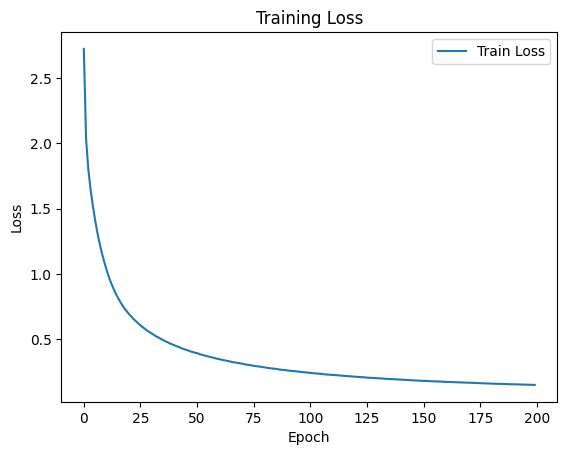

In [15]:
# Plot epoch-wise training loss
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

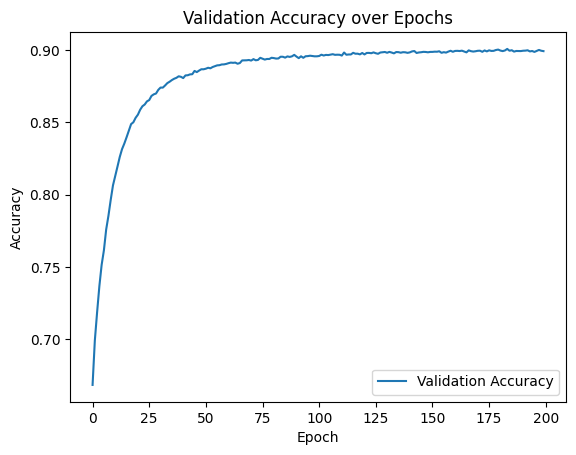

In [16]:
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.show()

In [17]:
# Save the model
torch.save(model.state_dict(),'transformer_model.pth')

In [18]:
# Load the state dictionary from the saved file

# model.load_state_dict(torch.load('transformer_model.pth'))


Test_accuracy = compute_accuracy(model, dataloaders.test_loader)

print(f"Test Accuracy: {Test_accuracy:.5f}")

Test Accuracy: 0.89770


In [19]:
# Evaluate on test set
test_bleu_score = evaluate(model, dataloaders.test_loader,20)
print(f"Test BLEU Score: {test_bleu_score:.4f}")

src:  ! I didn ' t realize you could speak French. "
trg:  Je n ' ai pas pris conscience que vous saviez parler français. "
pred: ! Je n ' ai pas pris conscience que tu savais parler français. "
src:  ! I don ' t want to meet your parents. "
trg:  Je ne veux pas rencontrer tes parents. "
pred: ! Je ne veux pas rencontrer tes parents. "
src:  ! This stone was so heavy that I could not lift it. "
trg:  Cette pierre était si lour de que je n ' ai pas pu la sou lever. "
pred: ! Cette pierre était si lour de que je ne pouvais le sou lever. "
Test BLEU Score: 46.3505
